In [1331]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import datetime as dt
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman
import datetime as dt
from linearmodels.iv import IV2SLS

%matplotlib inline

## Import Data

In [1332]:
price_df       = pd.read_csv('../data/electricity/elc_retail_price_monthly.csv', na_values = 'NM')
sales_df       = pd.read_csv('../data/electricity/elc_retail_sales_monthly.csv', na_values = 'NM')
fossil_cost_df = pd.read_csv('../data/fossil/avg_cost_fossil.csv', na_values = ['W', '--', 'NM'])
pcepi_df       = pd.read_csv('../data/inflation/us_pcepi.csv')
ddd_df        = pd.read_csv('../data/temperature/state_monthly_hdd_cdd.csv')

## Clean Data

In [1333]:
# Fix state names
sales_df['State']       = sales_df['State'].apply(lambda x: x.strip().lower()) 
price_df['State']       = price_df['State'].apply(lambda x: x.strip().lower()) 
fossil_cost_df['state'] = fossil_cost_df['state'].apply(lambda x: x.strip().lower()) 

# Fix dates
pcepi_df['month'] = pcepi_df['DATE'].apply(lambda x: x[:1])
pcepi_df['year']  = pcepi_df['DATE'].apply(lambda x: x[-4:])
ddd_df['month']   = ddd_df['month'].astype(str)
ddd_df['year']    = ddd_df['year'].astype(str)


# Reshape dataframes
sales_melt_df  = pd.melt(sales_df, id_vars = ['State'], value_vars = sales_df.columns[1:],
       var_name = 'date', value_name = 'load')


price_melt_df  = pd.melt(price_df, id_vars = ['State'], value_vars = price_df.columns[1:],
       var_name = 'date', value_name = 'price')


fossil_cost_df = pd.melt(fossil_cost_df, id_vars = ['state', 'fuel'], value_vars = fossil_cost_df.columns[4:],
       var_name = 'date', value_name = 'cost').reset_index(drop = True)
fossil_cost_df['cost'] = fossil_cost_df['cost'].fillna(-1234)
fossil_cost_df = fossil_cost_df.groupby(['state', 'date', 'fuel'])['cost'].sum().unstack('fuel').reset_index()
fossil_cost_df.columns = (list(fossil_cost_df.columns[:2]) + 
                          [x.strip().replace(' ', '_') + '_cost' for x in fossil_cost_df.columns[2:]])

In [1334]:
data_df = price_melt_df.merge(sales_melt_df, on = ['State', 'date']).rename(columns = {'State': 'state'}).merge(
            fossil_cost_df, on = ['state', 'date'])

# Month abbreviations
month_abrv_dict = dict(zip(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                          range(1,13)))

# Clean up columns
data_df['state'] = data_df['state'].apply(lambda x: x.strip().lower()) 
data_df['month'] = data_df['date'].apply(lambda x: str(month_abrv_dict.get(x.split('-')[0])))
data_df['year']  = data_df['date'].apply(lambda x: str(2000+int(x.split('-')[1])))
data_df['price'] = pd.to_numeric(data_df['price'])/100
data_df['load']  = pd.to_numeric(data_df['load'])

# Merge with pcepi and ddd data
data_df = data_df.merge(pcepi_df, on =['month', 'year']).drop('DATE', axis = 1).merge(
                        ddd_df, on = ['state', 'month', 'year'])

# Fix entries in fuel cost
fuel_cost_cols = [x for x in data_df.columns if 'cost' in x]
for fuel_cost_col in fuel_cost_cols:
    data_df[fuel_cost_col] = pd.to_numeric(fossil_cost_df[fuel_cost_col]).apply(
        lambda x: np.nan if (x == -1234 or x == 0) else x)
    
# Adjust for inflation
for price_col in (fuel_cost_cols + ['price']):
    data_df[price_col] = data_df[price_col]*100/data_df['PCEPI']
    
# Fix date columns
data_df['month'] = data_df['month'].astype(int) 
data_df['year']  = data_df['year'].astype(int)  

In [1335]:
data_df.head()

,state,date,price,load,coal_cost,natural_gas_cost,petroleum_coke_cost,petroleum_liquids_cost,month,year,PCEPI,CDD,HDD
0,connecticut,Jan-11,0.186104,1372.0,NaN,NaN,NaN,NaN,1,2011,96.774,0.0,1273.0
1,connecticut,Jan-11,0.182463,1372.0,NaN,NaN,NaN,NaN,1,2011,98.705,0.0,1273.0
2,connecticut,Jan-11,0.182088,1372.0,NaN,NaN,NaN,NaN,1,2011,98.908,0.0,1273.0
3,connecticut,Jan-11,0.181984,1372.0,59.566513,4.779467,NaN,129.490224,1,2011,98.965,0.0,1273.0
4,maine,Jan-11,0.162440,441.0,NaN,2.314671,NaN,NaN,1,2011,96.774,0.0,1431.0


## Construct Reg Data

In [1355]:
def drop_outliers(df, columns, frac = 0.05):
    
    df = df.copy()
    
    # Mark outliers for each column
    for column in columns:
        cut_low, cut_high = df[column].quantile([frac/2, (1-frac/2)])
        df[column + '_keep'] = ((df[column] < cut_high) & (df[column] > cut_low)).astype(int)
        
    # Subset to observations that aren't outliers for any column
    query_str = ' & '.join([x + '_keep == 1' for x in columns])
    
    return df.query(query_str).drop([x + '_keep' for x in columns], axis = 1).copy()

In [1401]:
samples = int(1e6)

# Subset dataframe for relevant variables
em_sample_df = data_df[['state', 'price', 'load', 'month', 'year', 'coal_cost', 'CDD', 'HDD']].copy()

# Drop missing and outliers
em_sample_df[~em_sample_df.isna().any(axis = 1)]
em_sample_df = drop_outliers(em_sample_df, columns = ['price', 'load', 'coal_cost'])

print('Preliminary Data Set Observations:  ', 
      len(df_drop_na(data_df[['state', 'price', 'load', 'month', 'year', 'coal_cost']], 
               cols = ['state', 'price', 'load', 'month', 'year', 'coal_cost'])))

# Create two subsample dataframes
em_sample_df_1 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_1.columns = [x + '_1' for x in em_sample_df_1.columns] 
em_sample_df_2 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_2.columns = [x + '_2' for x in em_sample_df_2.columns] 

# Concat these two sample dfs
em_concat_df = pd.concat([em_sample_df_1, em_sample_df_2], axis = 1).copy()

# Add reg data columns
em_concat_df['ln_load_rel']    = np.log(np.divide(em_concat_df['load_1'], em_concat_df['load_2']))
em_concat_df['ln_price_rel']   = np.log(np.divide(em_concat_df['price_1'], em_concat_df['price_2']))
em_concat_df['ln_coal_rel']   = np.log(np.divide(em_concat_df['coal_cost_1'], em_concat_df['coal_cost_2']))

# Regressions should be done with pairs of data for the same state
reg_data_df = em_concat_df.query('state_1 == state_2').drop_duplicates().reset_index(drop = True).copy()
reg_data_df['time_diff'] = reg_data_df.apply(lambda x: dt.datetime(x.year_1, x.month_1, 1) - dt.datetime(x.year_2, x.month_2, 1), 
                                             axis = 1).apply(lambda x: x.days)

reg_data_df = reg_data_df.sample(n=10000)
print('Regression Data Set Observations: ', len(reg_data_df))

Preliminary Data Set Observations:   993
Regression Data Set Observations:  10000


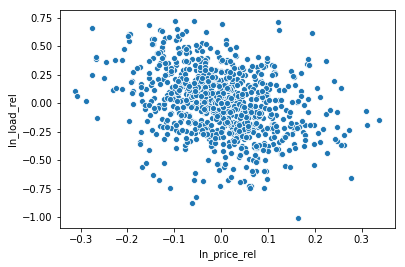

In [1370]:
sns.scatterplot(x = 'ln_price_rel', y = 'ln_load_rel', data = reg_data_df.sample(n=1000))

## Estimation

### OLS

In [1272]:
smf.ols('ln_load_rel~ ln_price_rel', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     1061.
Date:                Fri, 05 Apr 2019   Prob (F-statistic):          1.87e-221
Time:                        14:06:12   Log-Likelihood:                -1212.1
No. Observations:               10242   AIC:                             2428.
Df Residuals:                   10240   BIC:                             2443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0005      0.003     -0.168      0.867      -0.006       0.005
ln_price_rel    -0.9062      0.028    -32.566      0.000      -0.961      -0.852
==============================================================================
Omnibus:                       36.758   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.448
Skew:                           0.074   Prob(JB):                     2.23e-10
Kurtosis:                       3.287   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1273]:
smf.ols('ln_load_rel~ ln_price_rel + C(state_1) + C(state_2)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     21.90
Date:                Fri, 05 Apr 2019   Prob (F-statistic):          1.13e-185
Time:                        14:06:12   Log-Likelihood:                -1194.2
No. Observations:               10242   AIC:                             2490.
Df Residuals:                   10191   BIC:                             2859.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.0094      0.019     -0.503      0.615      -0.046       0.027
C(state_1)[T.alaska]                1.095e+12   8.07e+11      1.357      0.175   -4.87e+11    2.68e+12
C(state_1)[T.arizona]               5.477e+11   3.93e+11      1.393      0.164   -2.23e+11    1.32e+12
C(state_1)[T.arkansas]             -4.817e+08   9.82e+11     -0.000      1.000   -1.92e+12    1.92e+12
C(state_1)[T.california]           -2.239e+12   1.48e+12     -1.510      0.131   -5.15e+12    6.68e+11
C(state_1)[T.colorado]              2.489e+11   3.97e+11      0.627      0.530   -5.29e+11    1.03e+12
C(state_1)[T.connecticut]          -2.595e+11   6.11e+11     -0.425      0.671   -1.46e+12    9.38e+11
C(state_1)[T.delaware]              7.957e+11    5.4e+11      1.475      0.140   -2.62e+11    1.85e+12
C(state_1)[T.district of columbia] -1.874e+10   9.05e+11     -0.021      0.983   -1.79e+12    1.76e+12
C(state_1)[T.florida]               2.726e+12   1.48e+12      1.837      0.066   -1.82e+11    5.64e+12
C(state_1)[T.georgia]              -4.599e+08   1.61e+10     -0.029      0.977    -3.2e+10    3.11e+10
C(state_1)[T.idaho]                -6.716e+11   3.87e+11     -1.738      0.082   -1.43e+12     8.6e+10
C(state_1)[T.illinois]             -1.108e+12   6.92e+11     -1.602      0.109   -2.46e+12    2.48e+11
C(state_1)[T.indiana]                6.16e+11   4.14e+11      1.487      0.137   -1.96e+11    1.43e+12
C(state_1)[T.iowa]                 -5.198e+10   6.16e+10     -0.844      0.399   -1.73e+11    6.88e+10
C(state_1)[T.kansas]                1.255e+11   6.94e+11      0.181      0.857   -1.23e+12    1.49e+12
C(state_1)[T.kentucky]             -4.718e+11   8.51e+11     -0.554      0.579   -2.14e+12     1.2e+12
C(state_1)[T.louisiana]            -1.776e+12   1.19e+12     -1.493      0.135   -4.11e+12    5.55e+11
C(state_1)[T.maine]                -2.014e+11   8.32e+11     -0.242      0.809   -1.83e+12    1.43e+12
C(state_1)[T.maryland]              7.206e+11   5.15e+11      1.400      0.161   -2.88e+11    1.73e+12
C(state_1)[T.massachusetts]         2.279e+10   4.07e+10      0.561      0.575   -5.69e+10    1.02e+11
C(state_1)[T.michigan]             -9.219e+11    5.5e+11     -1.677      0.094      -2e+12    1.55e+11
C(state_1)[T.minnesota]             3.516e+09   6.02e+10      0.058      0.953   -1.14e+11    1.22e+11
C(state_1)[T.mississippi]          -3.457e+09    8.9e+11     -0.004      0.997   -1.75e+12    1.74e+12
C(state_1)[T.missouri]             -1.823e+12   1.37e+12     -1.328      0.184   -4.52e+12    8.69e+11
C(state_1)[T.montana]              -1.037e+12   1.13e+12     -0.918      0.359   -3.25e+12    1.18e+12
C(state_1)[T.nebraska]              1.946e+11   1.59e+12      0.122      0.903   -2.93e+12    3.

In [1274]:
smf.ols('ln_load_rel~ ln_price_rel + C(month_1) + C(month_2)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     808.5
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:06:12   Log-Likelihood:                 2646.3
No. Observations:               10242   AIC:                            -5257.
Df Residuals:                   10224   BIC:                            -5126.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0061      0.004      1.483      0.138      -0.002       0.014
C(month_1)[T.2]    -0.1734      0.007    -24.388      0.000      -0.187      -0.159
C(month_1)[T.3]    -0.2256      0.007    -31.411      0.000      -0.240      -0.211
C(month_1)[T.4]    -0.3899      0.007    -52.971      0.000      -0.404      -0.375
C(month_1)[T.5]    -0.3556      0.007    -47.693      0.000      -0.370      -0.341
C(month_1)[T.6]    -0.1394      0.007    -19.173      0.000      -0.154      -0.125
C(month_1)[T.7]     0.0701      0.007      9.458      0.000       0.056       0.085
C(month_1)[T.8]     0.0235      0.008      3.121      0.002       0.009       0.038
C(month_1)[T.9]    -0.1675      0.007    -22.734      0.000      -0.182      -0.153
C(month_2)[T.2]     0.1626      0.007     22.410      0.000       0.148       0.177
C(month_2)[T.3]     0.2163      0.007     30.101      0.000       0.202       0.230
C(month_2)[T.4]     0.3834      0.007     52.171      0.000       0.369       0.398
C(month_2)[T.5]     0.3440      0.007     46.095      0.000       0.329       0.359
C(month_2)[T.6]     0.1393      0.007     18.574      0.000       0.125       0.154
C(month_2)[T.7]    -0.0634      0.007     -8.717      0.000      -0.078      -0.049
C(month_2)[T.8]    -0.0175      0.007     -2.376      0.018      -0.032      -0.003
C(month_2)[T.9]     0.1546      0.007     20.800      0.000       0.140       0.169
ln_price_rel       -0.5454      0.023    -23.956      0.000      -0.590      -0.501
==============================================================================
Omnibus:                      485.946   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1652.024
Skew:                           0.113   Prob(JB):                         0.00
Kurtosis:                       4.955   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1275]:
smf.ols('ln_load_rel~ ln_price_rel + C(state_1) + C(state_2) + C(month_1) + C(month_2)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     208.3
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:06:13   Log-Likelihood:                 2660.9
No. Observations:               10242   AIC:                            -5188.
Df Residuals:                   10175   BIC:                            -4703.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.0014      0.013      0.107      0.915      -0.025       0.028
C(state_1)[T.alaska]                4.323e+11   5.54e+11      0.781      0.435   -6.53e+11    1.52e+12
C(state_1)[T.arizona]               1.175e+11    2.7e+11      0.435      0.663   -4.12e+11    6.47e+11
C(state_1)[T.arkansas]              5.093e+11   6.77e+11      0.753      0.452   -8.17e+11    1.84e+12
C(state_1)[T.california]           -5.291e+11   1.05e+12     -0.505      0.613   -2.58e+12    1.52e+12
C(state_1)[T.colorado]              5.772e+10   2.95e+11      0.196      0.845    -5.2e+11    6.35e+11
C(state_1)[T.connecticut]           7.226e+10   4.38e+11      0.165      0.869   -7.86e+11    9.31e+11
C(state_1)[T.delaware]              4.819e+11    3.9e+11      1.235      0.217   -2.83e+11    1.25e+12
C(state_1)[T.district of columbia] -6.727e+09   6.38e+11     -0.011      0.992   -1.26e+12    1.24e+12
C(state_1)[T.florida]               2.824e+12   1.04e+12      2.726      0.006    7.93e+11    4.85e+12
C(state_1)[T.georgia]              -3.739e+10   3.18e+10     -1.176      0.240   -9.97e+10    2.49e+10
C(state_1)[T.idaho]                -2.166e+11   2.72e+11     -0.796      0.426    -7.5e+11    3.17e+11
C(state_1)[T.illinois]             -5.665e+11   4.98e+11     -1.138      0.255   -1.54e+12    4.09e+11
C(state_1)[T.indiana]               2.946e+11   2.57e+11      1.146      0.252   -2.09e+11    7.99e+11
C(state_1)[T.iowa]                 -4.521e+09   3.28e+10     -0.138      0.890   -6.87e+10    5.97e+10
C(state_1)[T.kansas]               -1.073e+11      5e+11     -0.215      0.830   -1.09e+12    8.73e+11
C(state_1)[T.kentucky]              1.771e+11   5.88e+11      0.301      0.763   -9.76e+11    1.33e+12
C(state_1)[T.louisiana]            -1.806e+12   9.03e+11     -2.000      0.046   -3.58e+12   -3.59e+10
C(state_1)[T.maine]                -6.137e+11   6.06e+11     -1.012      0.311    -1.8e+12    5.75e+11
C(state_1)[T.maryland]              3.271e+11   4.39e+11      0.745      0.456   -5.33e+11    1.19e+12
C(state_1)[T.massachusetts]         5.049e+09   4.53e+10      0.111      0.911   -8.38e+10    9.39e+10
C(state_1)[T.michigan]             -3.698e+11   4.09e+11     -0.905      0.366   -1.17e+12    4.32e+11
C(state_1)[T.minnesota]             3.737e+10   1.51e+10      2.477      0.013     7.8e+09    6.69e+10
C(state_1)[T.mississippi]           8.817e+11   6.13e+11      1.437      0.151   -3.21e+11    2.08e+12
C(state_1)[T.missouri]             -1.587e+11   9.99e+11     -0.159      0.874   -2.12e+12     1.8e+12
C(state_1)[T.montana]               5.812e+11   8.64e+11      0.673      0.501   -1.11e+12    2.27e+12
C(state_1)[T.nebraska]             -4.002e+11   1.07e+12     -0.376      0.707   -2.49e+12    1.

In [1276]:
smf.ols('ln_load_rel~ ln_price_rel + C(state_1) + C(state_2) + C(month_1) + C(month_2) + time_diff', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     207.8
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:06:13   Log-Likelihood:                 2698.0
No. Observations:               10242   AIC:                            -5260.
Df Residuals:                   10174   BIC:                            -4768.
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.0056      0.013      0.432      0.665      -0.020       0.031
C(state_1)[T.alaska]                   0.0027      0.015      0.184      0.854      -0.026       0.032
C(state_1)[T.arizona]                  0.0343      0.009      4.006      0.000       0.018       0.051
C(state_1)[T.arkansas]                -0.0040      0.009     -0.448      0.654      -0.022       0.014
C(state_1)[T.california]              -0.0048      0.008     -0.569      0.569      -0.021       0.012
C(state_1)[T.colorado]                -0.0026      0.009     -0.304      0.762      -0.020       0.014
C(state_1)[T.connecticut]              0.0005      0.009      0.055      0.956      -0.017       0.018
C(state_1)[T.delaware]                -0.0010      0.009     -0.112      0.911      -0.018       0.016
C(state_1)[T.district of columbia]     0.0056      0.012      0.475      0.635      -0.017       0.029
C(state_1)[T.florida]                  0.0153      0.014      1.088      0.276      -0.012       0.043
C(state_1)[T.georgia]                 -0.0031      0.009     -0.361      0.718      -0.020       0.014
C(state_1)[T.idaho]                   -0.0076      0.010     -0.785      0.433      -0.026       0.011
C(state_1)[T.illinois]                -0.0037      0.009     -0.427      0.669      -0.021       0.013
C(state_1)[T.indiana]                 -0.0023      0.009     -0.267      0.790      -0.019       0.015
C(state_1)[T.iowa]                    -0.0055      0.008     -0.648      0.517      -0.022       0.011
C(state_1)[T.kansas]                   0.0049      0.009      0.569      0.570      -0.012       0.022
C(state_1)[T.kentucky]                -0.0066      0.009     -0.747      0.455      -0.024       0.011
C(state_1)[T.louisiana]                0.0054      0.010      0.538      0.591      -0.014       0.025
C(state_1)[T.maine]                   -0.0064      0.009     -0.743      0.458      -0.023       0.010
C(state_1)[T.maryland]                 0.0059      0.009      0.670      0.503      -0.011       0.023
C(state_1)[T.massachusetts]           -0.0025      0.009     -0.281      0.779      -0.020       0.015
C(state_1)[T.michigan]                 0.0008      0.009      0.090      0.928      -0.016       0.018
C(state_1)[T.minnesota]               -0.0018      0.009     -0.203      0.839      -0.019       0.015
C(state_1)[T.mississippi]              0.0023      0.009      0.267      0.789      -0.015       0.020
C(state_1)[T.missouri]                 0.0011      0.009      0.128      0.898      -0.016       0.019
C(state_1)[T.montana]                  0.0058      0.009      0.662      0.508      -0.011       0.023
C(state_1)[T.nebraska]                -0.0023      0.009     -0.256      0.798      -0.020      

### 2SLS

In [1371]:
smf.ols('ln_load_rel ~ C(state_1) +  np.log(CDD_1+1) + np.log(CDD_2+1) + np.log(1+HDD_1) + np.log(1+HDD_2) + ln_price_rel',
       data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     16.97
Date:                Fri, 05 Apr 2019   Prob (F-statistic):          5.33e-148
Time:                        14:56:19   Log-Likelihood:                -658.20
No. Observations:               11868   AIC:                             1424.
Df Residuals:                   11814   BIC:                             1823.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.0079      0.026     -0.306      0.759      -0.058       0.043
C(state_1)[T.alaska]             0.0032      0.042      0.077      0.939      -0.079       0.085
C(state_1)[T.arizona]           -0.0096      0.021     -0.452      0.651      -0.051       0.032
C(state_1)[T.arkansas]          -0.0079      0.022     -0.367      0.714      -0.050       0.034
C(state_1)[T.california]         0.0113      0.025      0.458      0.647      -0.037       0.059
C(state_1)[T.colorado]           0.0172      0.020      0.862      0.389      -0.022       0.056
C(state_1)[T.connecticut]        0.0055      0.027      0.202      0.840      -0.048       0.059
C(state_1)[T.delaware]           0.0070      0.019      0.364      0.716      -0.031       0.045
C(state_1)[T.florida]            0.0024      0.037      0.066      0.947      -0.070       0.075
C(state_1)[T.georgia]            0.0082      0.019      0.424      0.671      -0.030       0.046
C(state_1)[T.idaho]             -0.0158      0.025     -0.640      0.522      -0.064       0.033
C(state_1)[T.illinois]           0.0135      0.019      0.692      0.489      -0.025       0.052
C(state_1)[T.indiana]            0.0085      0.020      0.420      0.675      -0.031       0.048
C(state_1)[T.iowa]               0.0087      0.022      0.397      0.692      -0.034       0.052
C(state_1)[T.kansas]             0.0014      0.020      0.072      0.943      -0.038       0.041
C(state_1)[T.kentucky]           0.0093      0.022      0.416      0.678      -0.035       0.053
C(state_1)[T.louisiana]          0.0003      0.028      0.011      0.991      -0.055       0.055
C(state_1)[T.maine]              0.0118      0.022      0.530      0.596      -0.032       0.055
C(state_1)[T.maryland]           0.0030      0.022      0.138      0.890      -0.040       0.046
C(state_1)[T.massachusetts]      0.0074      0.031      0.235      0.814      -0.054       0.069
C(state_1)[T.michigan]           0.0062      0.019      0.328      0.743      -0.031       0.043
C(state_1)[T.minnesota]          0.0145      0.027      0.532      0.595      -0.039       0.068
C(state_1)[T.mississippi]        0.0014      0.020      0.067      0.946      -0.039       0.041
C(state_1)[T.missouri]        -3.96e-05      0.022     -0.002      0.999      -0.043       0.043
C(state_1)[T.montana]           -0.0033      0.021     -0.154      0.878      -0.045       0.039
C(state_1)[T.nebraska]          -0.0004      0.026     -0.014      0.989      -0.051       0.050
C(state_1)[T.nevada]             0.0005      0.026      0.018      0.986      -0.050       0.051
C(state_1)[T.new hampshire]      0.0164      0.020      0.800      0.424      -0.024       0.057
C(state_1)[T.new jersey]         0.0124      0.019      0.641      0.522    

In [1372]:
smf.ols('ln_price_rel ~ ln_coal_rel + time_diff', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ln_price_rel   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     397.1
Date:                Fri, 05 Apr 2019   Prob (F-statistic):          1.14e-167
Time:                        14:56:20   Log-Likelihood:                 11724.
No. Observations:               11868   AIC:                        -2.344e+04
Df Residuals:                   11865   BIC:                        -2.342e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0004      0.001      0.521      0.602      -0.001       0.002
ln_coal_rel    -0.0211      0.002    -12.619      0.000      -0.024      -0.018
time_diff    1.454e-05   6.47e-07     22.461      0.000    1.33e-05    1.58e-05
==============================================================================
Omnibus:                      222.193   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              468.144
Skew:                          -0.003   Prob(JB):                    2.21e-102
Kurtosis:                       3.973   Cond. No.                     2.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1373]:
fit_iv = IV2SLS.from_formula('ln_load_rel ~ 1 +  C(state_1) +np.log(1+CDD_1) + '
                             'np.log(1+CDD_2) + np.log(1+HDD_1) + np.log(1+HDD_2)  + '
                             '[ln_price_rel ~ ln_coal_rel]', data = reg_data_df).fit()
fit_iv.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                     -6.0326
Estimator:                    IV-2SLS   Adj. R-squared:                -6.0641
No. Observations:               11868   F-statistic:                    98.216
Date:                Fri, Apr 05 2019   P-value (F-stat)                0.0002
Time:                        14:56:24   Distribution:                 chi2(53)
Cov. Estimator:                robust                                         
                                                                              
                                      Parameter Estimates                                       
================================================================================================
                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------
Intercept                       -0.0125     0.0567    -0.2206     0.8254     -0.1237      0.0987
C(state_1)[T.alaska]            -0.0238     0.0830    -0.2870     0.7741     -0.1865      0.1389
C(state_1)[T.arizona]           -0.0453     0.0601    -0.7533     0.4513     -0.1630      0.0725
C(state_1)[T.arkansas]          -0.0217     0.0308    -0.7039     0.4815     -0.0820      0.0387
C(state_1)[T.california]         0.0083     0.0644     0.1289     0.8975     -0.1179      0.1345
C(state_1)[T.colorado]           0.0210     0.0322     0.6513     0.5149     -0.0421      0.0840
C(state_1)[T.connecticut]        0.0260     0.0503     0.5180     0.6045     -0.0725      0.1245
C(state_1)[T.delaware]          -0.0009     0.0455    -0.0187     0.9851     -0.0901      0.0884
C(state_1)[T.florida]            0.0239     0.0655     0.3655     0.7147     -0.1045      0.1524
C(state_1)[T.georgia]            0.0229     0.0348     0.6564     0.5116     -0.0454      0.0911
C(state_1)[T.idaho]             -0.0241     0.0623    -0.3859     0.6995     -0.1462      0.0981
C(state_1)[T.illinois]           0.0075     0.0291     0.2571     0.7971     -0.0496      0.0646
C(state_1)[T.indiana]            0.0212     0.0328     0.6459     0.5183     -0.0430      0.0854
C(state_1)[T.iowa]              -0.0028     0.0658    -0.0422     0.9664     -0.1318      0.1263
C(state_1)[T.kansas]             0.0206     0.0482     0.4270     0.6694     -0.0739      0.1151
C(state_1)[T.kentucky]          -0.0089     0.0249    -0.3577     0.7206     -0.0577      0.0399
C(state_1)[T.louisiana]         -0.0071     0.0428    -0.1665     0.8678     -0.0910      0.0767
C(state_1)[T.maine]              0.0084     0.0614     0.1369     0.8911     -0.1120      0.1288
C(state_1)[T.maryland]           0.0199     0.0503     0.3953     0.6926     -0.0787      0.1185
C(state_1)[T.massachusetts]      0.0207     0.1069     0.1933     0.8467     -0.1889      0.2302
C(state_1)[T.michigan]           0.0094     0.0245     0.3829     0.7018     -0.0387      0.0574
C(state_1)[T.minnesota]         -0.0024     0.0527    -0.0453     0.9638     -0.1057      0.1009
C(state_1)[T.mississippi]        0.0093     0.0249     0.3729     0.7092     -0.0396      0.0582
C(state_1)[T.missouri]           0.0047     0.0736     0.0633     0.9495     -0.1395      0.1489
C(state_1)[T.montana]            0.0208     0.0230     0.9006     0.3678     -0.0244      0.0659
C(state_1)[T.nebraska]           0.0158     0.0911     0.1733     0.8624     -0.1628      0.1944
C(state_1)[T.nevada]            -0.0189     0.0594    -0.3189     0.7498     -0.1353      0.0974
C(state_1)[T.new hampshire]      0.0490     0.0495     0.9898     0.3223     -0.0480      0.1459
C(state_1)[T.new jersey]         0.0229     0.0337     0.6802     0.4964     -0.0431      0.0890
C(state_1)[T.new mexico]         0

In [1374]:
reg_data_df.to_csv('../data/processed/ces_monthly.csv', index = False)

### Instrument Free Estimation

The consistent estimate of the price parameter is given by 

$$\hat{\beta} = - \sqrt{ (\hat{\beta}_{OLS})^2 + Cov(\hat{\xi}_{OLS}, q)/Var(p)}$$

where $\hat{\beta}_{OLS}$  is obtained from quantity ~ price and $\hat{\xi}_{OLS}$ are the residuals

In [1375]:
fit = smf.ols('ln_load_rel ~ ln_price_rel +  C(state_1) +np.log(1+CDD_1) + np.log(1+CDD_2) + np.log(1+HDD_1) + np.log(1+HDD_2)', data = reg_data_df).fit()
fit.summary()
beta_hat_ols = fit.params['ln_price_rel']
reg_data_df['xi_hat_ols'] = reg_data_df['ln_load_rel'] - fit.predict()

In [1376]:
cov_xi_q = reg_data_df[['xi_hat_ols', 'ln_load_rel']].cov().iloc[0,1]
var_p    = np.var(reg_data_df['ln_price_rel'])
beta_d_hat = -np.sqrt(beta_hat_ols**2 + cov_xi_q/var_p)

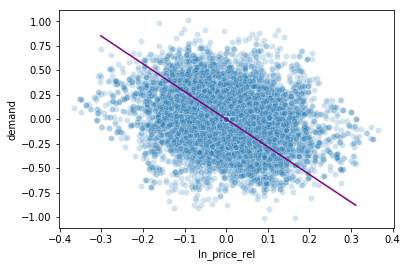

In [1377]:
reg_data_df['demand'] = reg_data_df['ln_price_rel']*beta_d_hat
sns.scatterplot(x ='ln_price_rel', y = 'ln_load_rel', alpha = 0.2, data = reg_data_df)
sns.lineplot(x ='ln_price_rel', y = 'demand', color = 'purple', data = reg_data_df.sample(n=100))

In [1378]:
-beta_d_hat

2.823114035176829

### Schwarz et al.

In [1379]:
# Subset dataframe for relevant variables
em_sample_df = data_df.copy()
em_sample_df = df_drop_na(em_sample_df, ['coal_cost'])

# Drop outliers
em_sample_df = drop_outliers(em_sample_df, columns = ['price', 'load'])

In [1380]:
em_sample_df['ln_E_ym']    = np.log(em_sample_df['load'])
em_sample_df['ln_P_ym']    = np.log(em_sample_df['price'])

em_sample_df['ln_E_ym_gm'] = np.mean(em_sample_df['ln_E_ym'])
em_sample_df['ln_P_ym_gm'] = np.mean(em_sample_df['ln_P_ym'])

em_sample_df['E'] = em_sample_df['ln_E_ym'] - em_sample_df['ln_E_ym_gm']
em_sample_df['P'] = em_sample_df['ln_P_ym'] - em_sample_df['ln_P_ym_gm']

em_sample_df['exp_m'] = em_sample_df['price']*em_sample_df['load']
em_sample_df['temp']  = em_sample_df.groupby(['year'])['exp_m'].transform('sum')
em_sample_df['w_ym']  = np.divide(em_sample_df['price']*em_sample_df['load'],
                                 em_sample_df['temp'])
em_sample_df['w_ym_am'] = em_sample_df.groupby(['year'])['w_ym'].transform('mean')
em_sample_df['temp']    = np.multiply(em_sample_df['w_ym'] + em_sample_df['w_ym_am'],
                                      em_sample_df['P'])
em_sample_df['D'] = (1/2)*em_sample_df.groupby(['year'])['temp'].transform('sum')

In [1381]:
smf.ols('E ~ C(state) + np.log(CDD+1) + np.log(HDD+1) + np.add(D, -P) + np.multiply(D, -1)',
       data = em_sample_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      E   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     430.6
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:56:35   Log-Likelihood:                 251.94
No. Observations:                 900   AIC:                            -397.9
Df Residuals:                     847   BIC:                            -143.3
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5582      0.057      9.738      0.000       0.446       0.671
C(state)[T.alaska]            -2.1496      0.099    -21.675      0.000      -2.344      -1.955
C(state)[T.arizona]            0.0252      0.056      0.447      0.655      -0.085       0.136
C(state)[T.arkansas]          -0.6890      0.061    -11.246      0.000      -0.809      -0.569
C(state)[T.california]         1.2491      0.076     16.339      0.000       1.099       1.399
C(state)[T.colorado]          -0.6172      0.057    -10.817      0.000      -0.729      -0.505
C(state)[T.connecticut]       -0.5427      0.089     -6.067      0.000      -0.718      -0.367
C(state)[T.delaware]          -1.7942      0.059    -30.342      0.000      -1.910      -1.678
C(state)[T.florida]            1.1122      0.074     14.984      0.000       0.967       1.258
C(state)[T.georgia]            0.6079      0.055     11.015      0.000       0.500       0.716
C(state)[T.idaho]             -1.5409      0.066    -23.398      0.000      -1.670      -1.412
C(state)[T.illinois]           0.3760      0.056      6.729      0.000       0.266       0.486
C(state)[T.indiana]            0.0546      0.057      0.956      0.339      -0.058       0.167
C(state)[T.iowa]              -0.7413      0.059    -12.625      0.000      -0.857      -0.626
C(state)[T.kansas]            -0.8127      0.056    -14.508      0.000      -0.923      -0.703
C(state)[T.kentucky]          -0.2483      0.063     -3.941      0.000      -0.372      -0.125
C(state)[T.louisiana]         -0.2019      0.069     -2.912      0.004      -0.338      -0.066
C(state)[T.maine]             -1.7748      0.072    -24.611      0.000      -1.916      -1.633
C(state)[T.maryland]          -0.0060      0.062     -0.097      0.923      -0.128       0.116
C(state)[T.massachusetts]     -0.2384      0.081     -2.960      0.003      -0.397      -0.080
C(state)[T.michigan]           0.1892      0.063      3.024      0.003       0.066       0.312
C(state)[T.minnesota]         -0.3372      0.065     -5.223      0.000      -0.464      -0.210
C(state)[T.mississippi]       -0.5757      0.057    -10.093      0.000      -0.688      -0.464
C(state)[T.missouri]           0.0870      0.060      1.462      0.144      -0.030       0.204
C(state)[T.montana]           -2.0218      0.058    -34.860      0.000      -2.136      -1.908
C(state)[T.nebraska]          -1.2754      0.065    -19.720      0.000      -1.402      -1.148
C(state)[T.nevada]            -0.9222      0.064    -14.391      0.000      -1.048      -0.796
C(state)[T.new hampshire]     -1.6273      0.080    -20.344      0.000      -1.784      -1.470
C(state)[T.new jersey]         0.1095      0.068      1.613      0.107      -0.024       0.243
C(state)[T.new mexico]        -1.5464      

In [1382]:
em_sample_df['reg_1'] = np.add(em_sample_df['D'], -em_sample_df['P'])
em_sample_df['reg_2'] = -em_sample_df['D']
em_sample_df['date_fmt'] = em_sample_df.apply(lambda x: str(x.month) + '/' + str(x.year), axis = 1)
em_sample_df.to_csv('../data/processed/ces_monthly_s.csv')

### Nonlinear Control IV

In [1393]:
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman

In [1394]:
samples = 3000
reg_data_sample_df = reg_data_df.sample(n=samples)

In [1395]:
t  = np.array(reg_data_sample_df[['CDD_1', 'CDD_2', 'HDD_1', 'HDD_2']])
w  = np.array(reg_data_sample_df['ln_coal_rel'])
p  = np.array(reg_data_sample_df['ln_price_rel'])
q  = np.array(reg_data_sample_df['ln_load_rel'])
tw = np.concatenate((t,w.reshape(-1,1)), axis = 1)

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='cccc', 
                              bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='cccc', 
                             bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(w)]).fit(w)

# Estimation of CE(P | T, W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[tw], reg_type='lc', var_type='ccccc', 
                             bw=bw_silverman(tw)).fit(tw)

In [1396]:
reg_data_sample_df['ce_q_t']  = ce_q_t
reg_data_sample_df['ce_p_t']  = ce_p_t
reg_data_sample_df['ce_p_w']  = ce_p_w
reg_data_sample_df['ce_p_tw'] = ce_p_tw

In [1397]:
smf.ols('np.add(ln_load_rel, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t)', data = reg_data_sample_df).fit(cov_type = 'HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.add(ln_load_rel, -ce_q_t)   R-squared:                       0.014
Model:                                      OLS   Adj. R-squared:                  0.014
Method:                           Least Squares   F-statistic:                     37.10
Date:                          Fri, 05 Apr 2019   Prob (F-statistic):           1.27e-09
Time:                                  14:59:06   Log-Likelihood:                 1291.5
No. Observations:                          3000   AIC:                            -2579.
Df Residuals:                              2998   BIC:                            -2567.
Df Model:                                     1                                         
Covariance Type:                            HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0001      0.003      0.050      0.960      -0.005       0.006
np.add(ce_p_tw, -ce_p_t)    -0.5456      0.090     -6.091      0.000      -0.721      -0.370
==============================================================================
Omnibus:                       84.930   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.883
Skew:                           0.016   Prob(JB):                     9.78e-47
Kurtosis:                       4.302   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [1398]:
# Add demeaned data
demean = lambda df: df - df.mean()
dmd_cols = ['ln_load_rel', 'ln_price_rel', 'CDD_1', 'CDD_2', 'HDD_1', 'HDD_2', 'ln_coal_rel']
reg_data_sample_df[[x + '_dmd' for x in dmd_cols]] = reg_data_sample_df.groupby(['state_1'])[dmd_cols].transform(demean)

t = np.array(reg_data_sample_df[['CDD_1_dmd', 'CDD_2_dmd', 'HDD_1_dmd', 'HDD_2_dmd']])
w = np.array(reg_data_sample_df['ln_coal_rel_dmd'])
p = np.array(reg_data_sample_df['ln_price_rel_dmd'])
q = np.array(reg_data_sample_df['ln_load_rel_dmd'])
tw = np.concatenate((t,w.reshape(-1,1)), axis = 1)

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='cccc', 
                              bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='cccc', 
                             bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(w)]).fit(w)

# Estimation of CE(P | T, W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[tw], reg_type='lc', var_type='ccccc', 
                             bw=bw_silverman(tw)).fit(tw)

In [1399]:
reg_data_sample_df['ce_q_t']  = ce_q_t
reg_data_sample_df['ce_p_t']  = ce_p_t
reg_data_sample_df['ce_p_w']  = ce_p_w
reg_data_sample_df['ce_p_tw'] = ce_p_tw

In [1400]:
smf.ols('np.add(ln_load_rel, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t)', data = reg_data_sample_df).fit(cov_type = 'HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.add(ln_load_rel, -ce_q_t)   R-squared:                       0.006
Model:                                      OLS   Adj. R-squared:                  0.006
Method:                           Least Squares   F-statistic:                     13.86
Date:                          Fri, 05 Apr 2019   Prob (F-statistic):           0.000201
Time:                                  14:59:17   Log-Likelihood:                 2125.5
No. Observations:                          3000   AIC:                            -4247.
Df Residuals:                              2998   BIC:                            -4235.
Df Model:                                     1                                         
Covariance Type:                            HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0011      0.002      0.520      0.603      -0.003       0.005
np.add(ce_p_tw, -ce_p_t)    -0.2391      0.064     -3.722      0.000      -0.365      -0.113
==============================================================================
Omnibus:                      144.329   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              513.591
Skew:                           0.015   Prob(JB):                    2.99e-112
Kurtosis:                       5.027   Cond. No.                         25.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""